# Demo: guided proposal for Ornstein-Uhlenbeck bridge 

In [1]:
import DiffusionBridge as db
import torch
import matplotlib.pyplot as plt
from DiffusionBridge.utils import normal_logpdf
plt.style.use('ggplot')


In [2]:
# problem settings
d = 2
alpha = torch.tensor(0.0)
beta = torch.tensor(2.0)
f = lambda t,x: alpha - beta * x 
sigma = torch.tensor(1.0)
T = torch.tensor(1.0)
M = 50
diffusion = db.diffusion.model(f, sigma, d, T, M)

# initial and terminal constraints
X0 = 1.0 * torch.ones(d)
XT = 1.0 * torch.ones(d)

# transition density
ratio = alpha / beta
transition_mean = lambda t,x: ratio + (x - ratio) * torch.exp(- beta * t)
transition_var = lambda t: (1.0 - torch.exp(-2.0 * beta * t)) / (2.0 * beta)
score_transition = lambda t,x: (transition_mean(t, X0) - x) / transition_var(t)
log_transition_density = normal_logpdf(XT.reshape(1, d), transition_mean(T, X0), transition_var(T))
print('log-transition density: ' + str(float(log_transition_density)))

# marginal density
marginal_var = lambda t: 1.0 / (1.0 / transition_var(t) + torch.exp(- 2.0 * beta * (T-t)) / transition_var(T-t))
marginal_mean = lambda t: (transition_mean(t,X0) / transition_var(t) + XT * torch.exp(- beta * (T-t)) / transition_var(T-t)) * marginal_var(t) 
score_marginal = lambda t,x: (marginal_mean(t) - x) / marginal_var(t)
grad_logh = lambda t,x: (XT - transition_mean(T - t, x)) * torch.exp(- beta * (T - t)) / transition_var(T - t)



log-transition density: -3.47947359085083


In [3]:
auxiliary_type = "ou"
initial_params = {
    "alpha": 3.0 * torch.ones(d),
    "beta": 3.0 * torch.ones(d),
}
niter = 1000

output = diffusion.learn_guided_proposal(
    auxiliary_type,
    initial_params,
    initial_state=X0,
    terminal_state=XT,
    minibatch=1000,
    num_iterations=niter,
    learning_rate=0.01,
)

Optimization iteration: 1 Loss: -1.962630271911621


/Users/jeremy/Library/CloudStorage/Dropbox/DiffusionBridge/DiffusionBridge/DiffusionBridge/auxiliary.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  name: torch.tensor(value, requires_grad=True)


Optimization iteration: 50 Loss: -2.0627660751342773
Optimization iteration: 100 Loss: -2.6248080730438232
Optimization iteration: 150 Loss: -2.782472610473633
Optimization iteration: 200 Loss: -2.8684849739074707
Optimization iteration: 250 Loss: -3.023099899291992
Optimization iteration: 300 Loss: -3.1003808975219727
Optimization iteration: 350 Loss: -3.136932849884033
Optimization iteration: 400 Loss: -3.1556081771850586
Optimization iteration: 450 Loss: -3.220707416534424
Optimization iteration: 500 Loss: -3.224325656890869
Optimization iteration: 550 Loss: -3.283677101135254
Optimization iteration: 600 Loss: -3.292145013809204
Optimization iteration: 650 Loss: -3.268282651901245
Optimization iteration: 700 Loss: -3.312321186065674
Optimization iteration: 750 Loss: -3.327258825302124
Optimization iteration: 800 Loss: -3.3267972469329834
Optimization iteration: 850 Loss: -3.306222438812256
Optimization iteration: 900 Loss: -3.3629298210144043
Optimization iteration: 950 Loss: -3.334

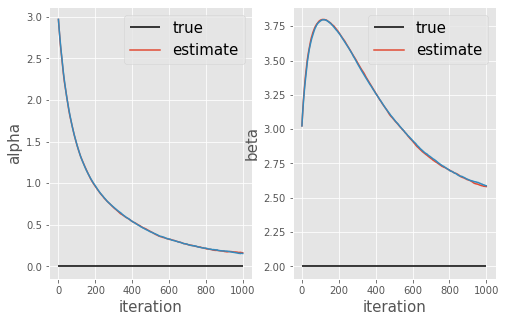

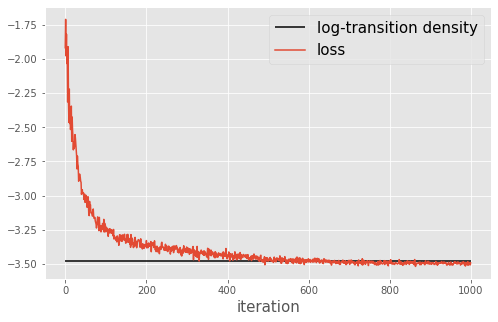

In [30]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.hlines(float(alpha), 0, niter, color="black")
plt.plot(output["params"]["alpha"])
plt.xlabel("iteration", fontsize=15)
plt.ylabel("alpha", fontsize=15)
plt.legend(["true", "estimate"], fontsize=15)

plt.subplot(1, 2, 2)
plt.hlines(float(beta), 0, num_iterations, color="black")
plt.plot(output["params"]["beta"])
plt.xlabel("iteration", fontsize=15)
plt.ylabel("beta", fontsize=15)
plt.legend(["true", "estimate"], fontsize=15)

plt.figure(figsize=(8, 5))
plt.hlines(float(log_transition_density), 0, num_iterations, color="black")
# plt.plot(output["loss"].detach().numpy())
plt.plot(loss_values.detach().numpy())
plt.xlabel("iteration", fontsize=15)
plt.legend(["log-transition density", "loss"], fontsize=15)

In [ ]:

# output = diffusion.learn_guided_proposal(
#     auxiliary_type,
#     initial_params,
#     initial_state=X0,
#     terminal_state=XT,
#     minibatch=1000,
#     num_iterations=niter,
#     learning_rate=0.01,
# )

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.hlines(float(alpha), 0, niter, color="black")
plt.plot(output["alpha"].detach().numpy())
plt.xlabel("iteration", fontsize=15)
plt.ylabel("alpha", fontsize=15)
plt.legend(["true", "estimate"], fontsize=15)

plt.subplot(1, 2, 2)
plt.hlines(float(beta), 0, niter, color="black")
plt.plot(output["beta"].detach().numpy())
plt.xlabel("iteration", fontsize=15)
plt.ylabel("beta", fontsize=15)
plt.legend(["true", "estimate"], fontsize=15)

plt.figure(figsize=(8, 5))
plt.hlines(float(log_transition_density), 0, niter, color="black")
plt.plot(output["loss"].detach().numpy())
plt.xlabel("iteration", fontsize=15)
plt.legend(["log-transition density", "loss"], fontsize=15)

In [ ]:
output["beta"]

In [ ]:
N = 2**10
proposal_drift = lambda t,x: diffusion.f(t,x) + diffusion.Sigma * output['aux_diffusion'].grad_logh(
                diffusion.invSigma, XT, diffusion.T, t, x
            )
with torch.no_grad():
    simulation_output = diffusion.simulate_proposal_bridge(proposal_drift, X0, XT, N, modify=True)
    trajectories = simulation_output['trajectories']
    log_proposal = simulation_output['logdensity']
log_target = diffusion.law_bridge(trajectories) 
log_weights = log_target - log_proposal

# importance sampling
max_log_weights = torch.max(log_weights)
weights = torch.exp(log_weights - max_log_weights)
norm_weights = weights / torch.sum(weights)
ess = 1.0 / torch.sum(norm_weights**2)
log_transition_estimate = torch.log(torch.mean(weights)) + max_log_weights
print("log-transition density:", float(log_transition_density))
print("IS log-transition estimate:", float(log_transition_estimate))
print("ESS%:", float(ess * 100 / N))

# independent Metropolis-Hastings
with torch.no_grad():
    initial = diffusion.simulate_proposal_bridge(proposal_drift, X0, XT, 1)
    current_trajectory = initial['trajectories']
    current_log_proposal = initial['logdensity'] 
current_log_target = diffusion.law_bridge(current_trajectory)
current_log_weight = current_log_target - current_log_proposal
num_accept = 0
for n in range(N):
    proposed_trajectory = trajectories[n, :, :]
    proposed_log_weight = log_weights[n]
    log_accept_prob = proposed_log_weight - current_log_weight

    if (torch.log(torch.rand(1)) < log_accept_prob):
        current_trajectory = proposed_trajectory.clone()
        current_log_weight = proposed_log_weight.clone()  
        num_accept += 1
accept_rate = num_accept / N
print("IMH acceptance rate:", accept_rate)